# DengAI

## Ideas

#### Models
- ARIMA (univariate)
- Vector Autoregressive (Multivariate)
- LSTM - relies on building data from earlier points
- LSTM with transfer learning
- Transfer learning between two data sets
- Fbprophet
- Dense network on last few data points
- Regression between output of VAR model and last few data points
- Regression trees
- CatBoost (Poisson loss function)
- Poisson Regression

#### Other
- Use PCA first
- Normalise columns
- Confirm that various variables are super-correlated
- Transform total_cases to be a flat distribution

#### Links
- http://drivendata.co/blog/dengue-benchmark/

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pydotplus

pd.set_option('display.max_columns', 500)

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Dropout

from catboost import CatBoostRegressor

/Users/Scott/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [41]:
display(df[list(df)][:5])

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,time,cat_cases,f_total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,0,0,1.609438
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,1,0,1.791759
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,2,0,1.609438
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,3,0,1.386294
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,4,0,1.945910


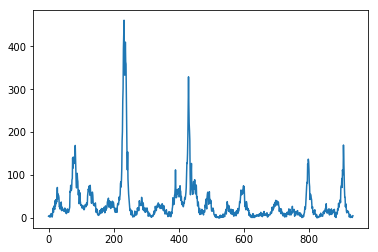

In [45]:
df[df['city']=='sj']['total_cases'].plot()

In [2]:
df      = pd.read_csv('data/dengue_features_train.csv')
y_tr    = pd.read_csv('data/dengue_labels_train.csv')
df_test = pd.read_csv('data/dengue_features_test.csv')
df['total_cases'] = y_tr['total_cases'] / 1
del(y_tr)
df['time'] = df.index
df.loc[(df['city']=='iq'), 'time'] -= df[df['city']=='iq'].index.min()
df['cat_cases'] = 0
df.loc[(df['total_cases']>10),'cat_cases']=1
df.loc[(df['total_cases']>40),'cat_cases']=2

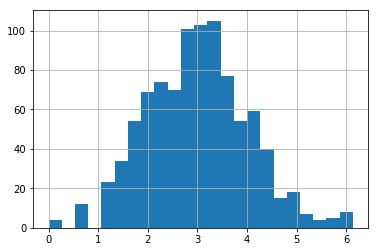

In [3]:
df['f_total_cases'] = np.log(df['total_cases']+1)
df[df['city']=='sj']['f_total_cases'].hist(bins='auto')

In [ ]:
df['f_total_cases'] = np.log(df['total_cases']+1)


In [4]:
list(df)

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases',
 'time',
 'cat_cases']

We can hypothesise that some of these are super-correlated. We test this...

# EDA - Visualisations

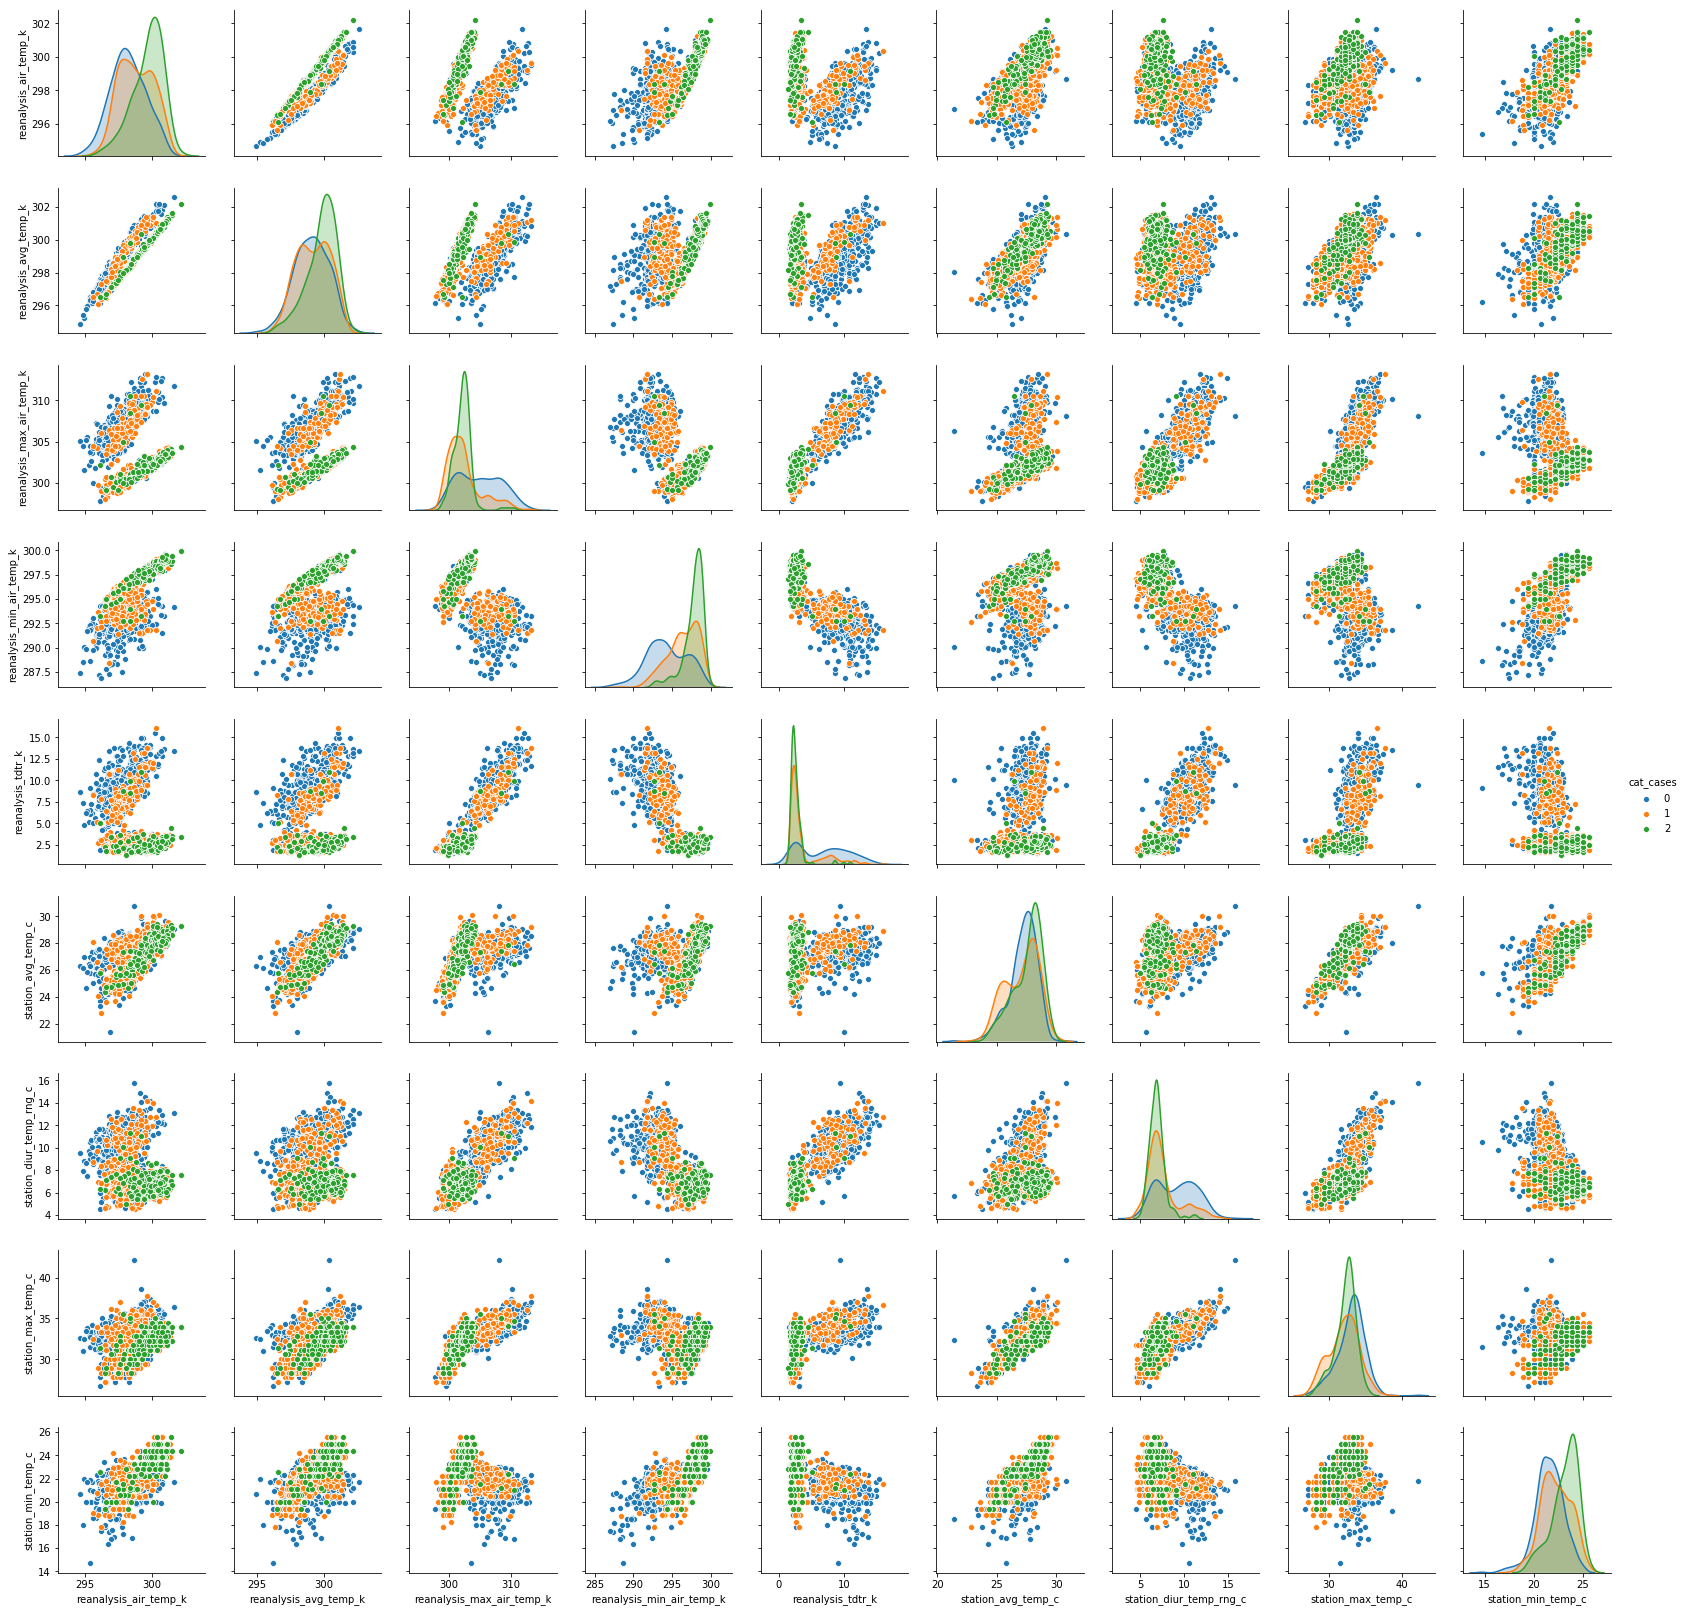

In [107]:
tempVars = [
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
]
sns.pairplot(df.dropna(),x_vars=tempVars,y_vars=tempVars,hue='cat_cases')

We see that all temperature variables are not simply equivalent. In particular, 'reanalysis_tdtr_k' seems to be a strong predictor of dengue fever. Below, we now visualise a set of varied data types.

/Users/Scott/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/Scott/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


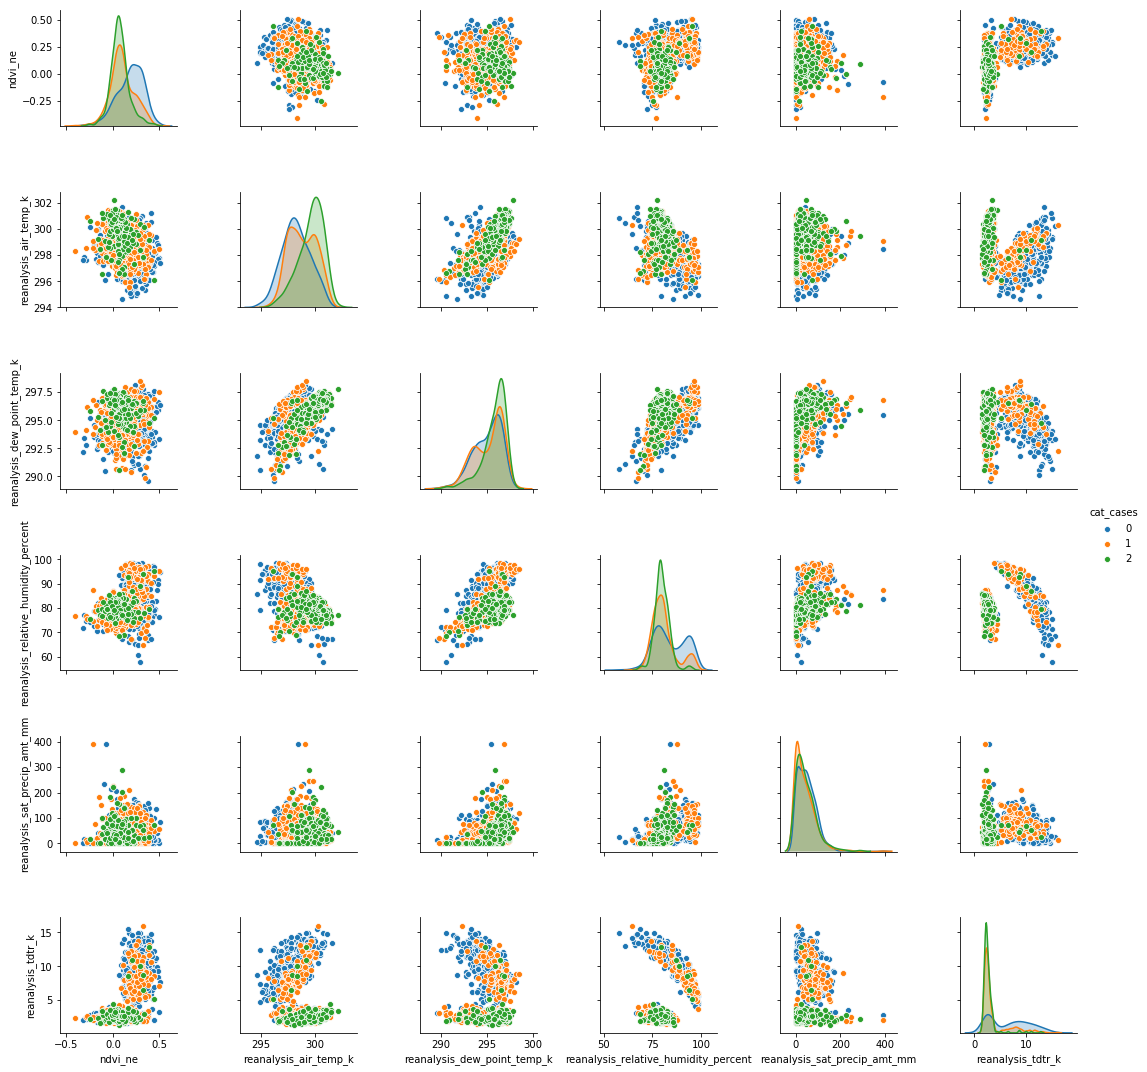

In [108]:
plotCols = [
 'ndvi_ne',
 'reanalysis_air_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_tdtr_k'
]
sns.pairplot(df,x_vars=plotCols,y_vars=plotCols,hue='cat_cases')

In [5]:
def showTimeCorr(var,ax,roll,col,city):
    ax2 = ax.twinx()
    tdtrRolled = df[df['city']==city][var].rolling(roll).sum()/roll
    tdtrRolled = tdtrRolled.fillna(tdtrRolled[:10].mean()).to_frame()
    tdtrRolled['time'] = df[df['city']==city]['time']
    sns.lineplot(x='time',y='total_cases',data=df[df['city']==city],ax=ax,color=col)
    sns.lineplot(x='time',y=var,data=tdtrRolled,ax=ax2,color='red',alpha=0.2)
    ax.set_xlabel(var)
    ax.set_ylabel('')
    ax2.set_ylabel('')
    ax.set_xticks([])
    return

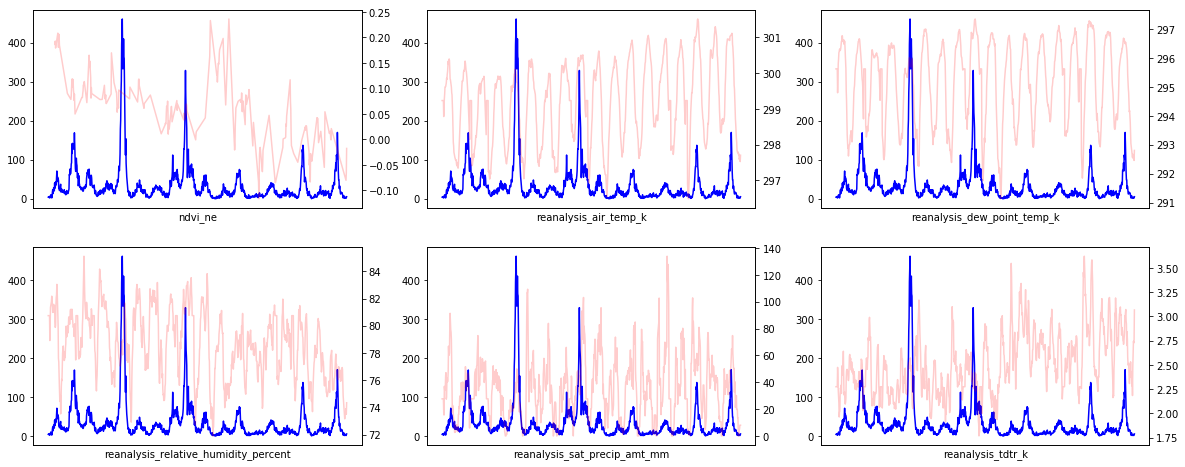

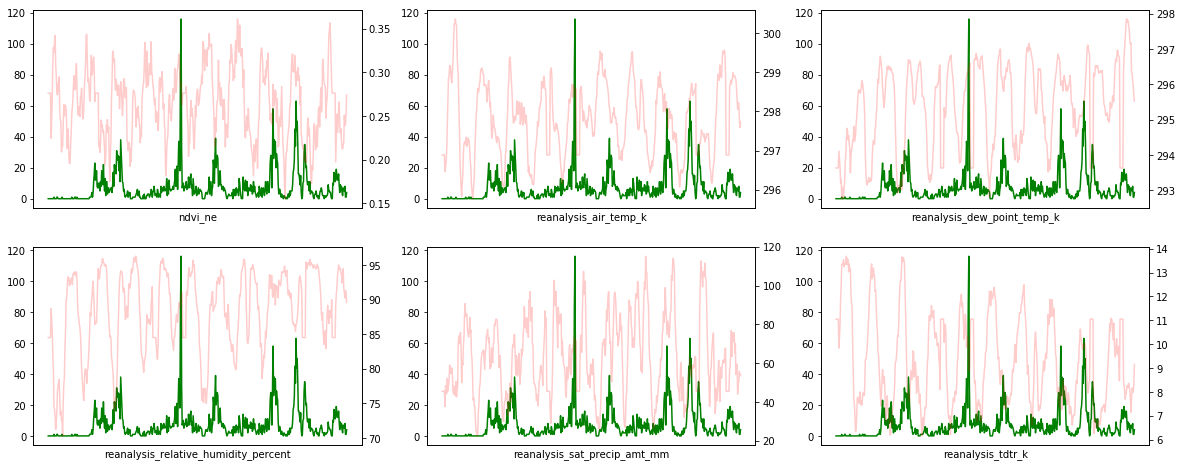

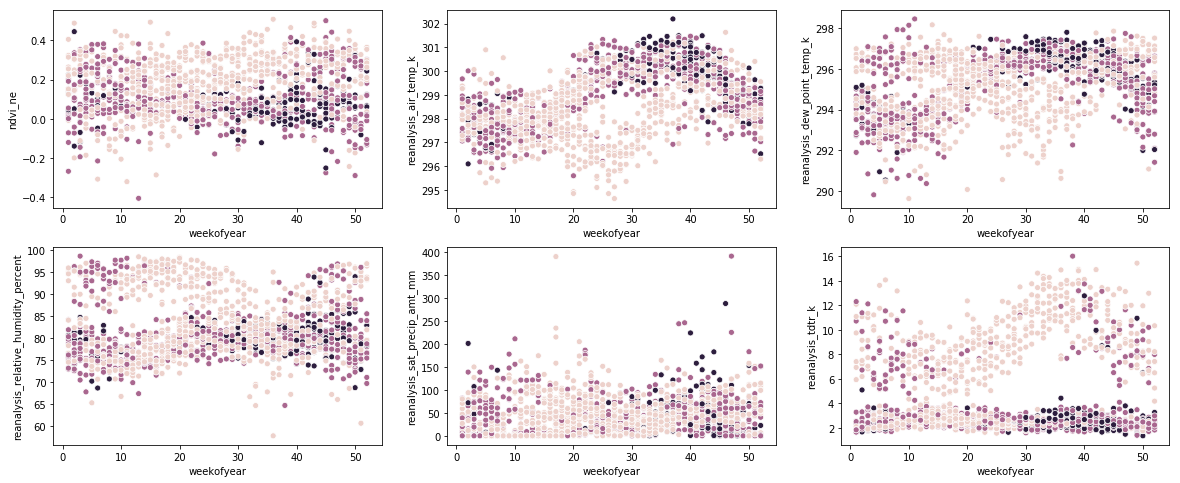

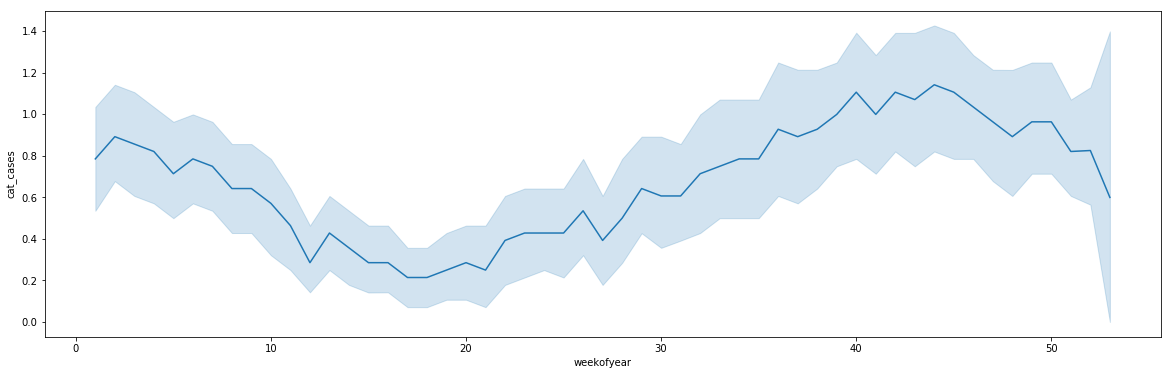

In [220]:
for col,city in zip(['blue','green'],['sj','iq']):
    fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(20,8))
    axes = axes.reshape(6)
    [showTimeCorr(var,ax,6,col,city) for var,ax in zip(plotCols,axes)]
    plt.show()
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(20,8))
axes = axes.reshape(6)
for i, col in enumerate(plotCols):
    sns.scatterplot(x='weekofyear',y=col,hue='cat_cases',data=df,legend=None,ax=axes[i])
plt.show()
plt.figure(figsize=(20,6))
sns.lineplot(x='weekofyear',y='cat_cases',data=df)
plt.show()

Since we only have 1456 data points to play with, deep-learning methods such as LSTMs may not converge well. We will therefore look at more traditional ML techniques.

In [202]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,time,cat_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0,0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1,0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,2,0
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,3,0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,4,0


# Data cleaning

#### Functions

In [4]:
def fillNanEitherSide(arrIn2D):
    '''Missing values are filled in as the average of the values either side.'''
    arr2D = arrIn2D.copy()
    for colIndex in range(arr2D.shape[1]):
        arr = arr2D[:,colIndex]
        lastValid = arr.mean()
        toFill = []
        fillVals = []
        for i,val in enumerate(arr):
            if np.isnan(val):
                toFill.append(i)
            else:
                for j in toFill:
                    arr[j] = (lastValid+val)/2
                lastValid = val
                toFill = []
    return arr2D

def getDataSplit(df,trainFrac):
    '''
    Set trainFrac->1 for test set
    '''
    dfC = df.copy()
    extraDrop = [
        'reanalysis_avg_temp_k',
        'reanalysis_max_air_temp_k'
    ]
    for col in ['year','week_start_date','cat_cases','time']+extraDrop:
        if col in list(df):
            dfC = dfC.drop(columns=[col]).reset_index(drop=1)
    
    trainCut = int(len(dfC)*trainFrac)
    
    if trainFrac<1:
        dfC_y = dfC['total_cases'].values
        dfC_ytr = dfC_y[:trainCut]
        dfC_ycv = dfC_y[trainCut:]
        dfC = dfC.drop(columns=['total_cases'])

    dfC = dfC.drop(columns=['city'])
    dfC_X = dfC.values
    dfC_X = fillNanEitherSide(dfC_X)
    dfC_Xtr = dfC_X[:trainCut]
    dfC_Xcv = dfC_X[trainCut:]

    scaler = preprocessing.MinMaxScaler()
    scaler.fit(dfC_Xtr)
    dfC_Xtr = scaler.transform(dfC_Xtr)

    if trainFrac<1:
        dfC_Xcv = scaler.transform(dfC_Xcv)
        return dfC_Xtr,dfC_ytr,dfC_Xcv,dfC_ycv
    else:
        return dfC_Xtr
    
def timeShiftedFeatures(X,y,k,skip=1,includeY=0):
    '''Produce a array where the last k of each feature is also a feature'''
    arr = X.copy()
    arrToRoll = arr[:,1:]
    for i in range(1,(k+1)*skip,skip):
        arr = np.concatenate(    
            (arr,
            np.roll(arrToRoll,i,0)
            ) , 1
        )
        if includeY:
            arr = np.concatenate(    
                (arr,
                np.roll(y.reshape(len(y),1),i,0)
                ) , 1
            )
    
    if type(y)==type(None):
        return arr[k:,:]
    return arr[k:,:] , y[k:]

#### Create datasets and shift

In [5]:
sj_Xtr,sj_ytr,sj_Xcv,sj_ycv = getDataSplit(df[df['city']=='sj'],0.7)
iq_Xtr,iq_ytr,iq_Xcv,iq_ycv = getDataSplit(df[df['city']=='iq'],0.7)

#### Apply PCA

In [6]:
pcaN = 5
sj_pca = PCA(pcaN)
iq_pca = PCA(pcaN)

sj_pca.fit(sj_Xtr)
sj_Xtr = sj_pca.transform(sj_Xtr)
sj_Xcv = sj_pca.transform(sj_Xcv)

iq_pca.fit(iq_Xtr)
iq_Xtr = iq_pca.transform(iq_Xtr)
iq_Xcv = iq_pca.transform(iq_Xcv)

#### Perform time-shifts

In [7]:
shift = 4
skip =  1
includeY = 0

sj_Xtr,sj_ytr = timeShiftedFeatures(sj_Xtr,sj_ytr,shift,skip=skip)
sj_Xcv,sj_ycv = timeShiftedFeatures(sj_Xcv,sj_ycv,shift,skip=skip)

iq_Xtr,iq_ytr = timeShiftedFeatures(iq_Xtr,iq_ytr,shift,skip=skip)
iq_Xcv,iq_ycv = timeShiftedFeatures(iq_Xcv,iq_ycv,shift,skip=skip)

# Model creation and testing

In [8]:
def layerFreeze(model,layers,mode):
    for lay in layers:
        if mode == 'U':
            model.layers[lay].trainable = True
        elif mode=='F':
            model.layers[lay].trainable == False
    model.compile(loss=model.loss, optimizer=model.optimizer)
    return model

def resetWeights(model):
    from tensorflow.keras.backend import get_session
    session = get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

def testModel(model,allData,verbose=0,testOnTrain=0): 
    epochs=50
    
    if testOnTrain==0: 
        sj_Xcv_ = sj_Xcv
        sj_ycv_ = sj_ycv
        iq_Xcv_ = iq_Xcv
        iq_ycv_ = iq_ycv
    if testOnTrain==1:
        sj_Xcv_ = sj_Xtr
        sj_ycv_ = sj_ytr
        iq_Xcv_ = iq_Xtr
        iq_ycv_ = iq_ytr
    
    if 'sklearn' in str(type(model)) or 'catboost' in str(type(model)):
        model.fit(sj_Xtr,sj_ytr)
        sj_yp = model.predict(sj_Xcv_)
        model.fit(iq_Xtr,iq_ytr)
        iq_yp = model.predict(iq_Xcv_)
            
    elif 'keras' in str(type(model)):
        model.fit(sj_Xtr,sj_ytr , epochs=epochs, verbose=verbose)
        sj_yp = model.predict(sj_Xcv_)
        #layerFreeze(model,(1,2),'F')
        model.fit(iq_Xtr,iq_ytr , epochs=epochs, verbose=verbose)
        #layerFreeze(model,(1,2),'U')
        iq_yp = model.predict(iq_Xcv_)
    
    totlen = len(sj_yp)+len(iq_yp)
    e1 = mean_absolute_error(sj_ycv_,sj_yp)
    e2 = mean_absolute_error(iq_ycv_,iq_yp)
    et = (
        e1*len(sj_yp)/totlen + 
        e2*len(iq_yp)/totlen
    )
    
    if verbose:
        print(e1)
        print(e2)
        print(et)
    
    return et, sj_yp, iq_yp

### Create models

#### Dense neural net

In [15]:
do=0.90
inputs = Input(shape=(sj_Xtr.shape[1],))
layer  = Dense(50,activation='relu',name='D1')(inputs)
layer  = Dropout(do)(layer)
layer  = Dense(50,activation='relu',name='D2')(layer)
layer  = Dropout(do)(layer)
layer  = Dense(50,activation='relu',name='D3')(layer)
layer  = Dropout(do)(layer)
layer  = Dense(1,activation='linear')(layer)
model  = Model(inputs=inputs,outputs=layer)
model.compile(loss='mae',optimizer='adam')

allData = (sj_Xtr,sj_ytr,sj_Xcv,sj_ycv, iq_Xtr,iq_ytr,iq_Xcv,iq_ycv)
et,sj_yp_nn,iq_yp_nn = testModel(model,allData,testOnTrain=0)
print(et)


11.6258844507


#### Random forest

In [16]:
model = RandomForestRegressor(30,'mae',max_depth=2,max_features='sqrt')

allData = (sj_Xtr,sj_ytr,sj_Xcv,sj_ycv, iq_Xtr,iq_ytr,iq_Xcv,iq_ycv)
et,sj_yp_rf,iq_yp_rf = testModel(model,allData)
print(et)

14.443978244


#### CatBoost

In [17]:
model = CatBoostRegressor(iterations=500,
                          learning_rate=.1,
                          random_strength = 100,
                          depth=5,
                          eval_metric='MAE',
                          random_seed = 23,
                          bagging_temperature = 20,
                          od_type='Iter',
                          metric_period = 100
)

allData = (sj_Xtr,sj_ytr,sj_Xcv,sj_ycv, iq_Xtr,iq_ytr,iq_Xcv,iq_ycv)
et,sj_yp_xg,iq_yp_xg = testModel(model,allData)
print(et)

0:	learn: 36.2403735	total: 96.2ms	remaining: 48s
100:	learn: 22.5115402	total: 1.12s	remaining: 4.43s
200:	learn: 20.8932330	total: 2.37s	remaining: 3.53s
300:	learn: 19.6632246	total: 3.48s	remaining: 2.3s
400:	learn: 18.5115276	total: 4.62s	remaining: 1.14s
499:	learn: 17.6596086	total: 5.61s	remaining: 0us
0:	learn: 6.1889140	total: 42.1ms	remaining: 21s
100:	learn: 3.4246525	total: 1.63s	remaining: 6.44s
200:	learn: 2.9495684	total: 3.05s	remaining: 4.54s
300:	learn: 2.6580322	total: 4.4s	remaining: 2.91s
400:	learn: 2.4493626	total: 5.73s	remaining: 1.41s
499:	learn: 2.2839331	total: 6.92s	remaining: 0us
20.3479024542


#### Test model

In [400]:
allData = (sj_Xtr,sj_ytr,sj_Xcv,sj_ycv, iq_Xtr,iq_ytr,iq_Xcv,iq_ycv)
et,sj_yp,iq_yp = testModel(model,allData)

In [171]:
sj_yp_rf = sj_yp_xg
iq_yp_rf = iq_yp_xg

#### Find optimal balancing between NN and RF

/Users/Scott/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


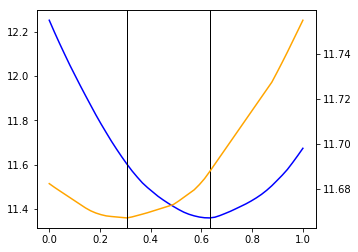

In [172]:
#Reshape NN output for combining with RF
sj_yp_nn = sj_yp_nn.reshape(len(sj_yp_nn))
iq_yp_nn = iq_yp_nn.reshape(len(iq_yp_nn))

a=0.5
b=0.5

outa = []
outb = []
lsp = np.linspace(0,1)
for a in lsp:
    sj_yp = (a*sj_yp_nn+(1-a)*sj_yp_rf)/2
    iq_yp = (b*iq_yp_nn+(1-b)*iq_yp_rf)/2
    esj = mean_absolute_error(sj_ycv,sj_yp)
    eiq = mean_absolute_error(iq_ycv,iq_yp)
    outa.append((esj*len(sj_yp) + eiq*len(iq_yp))/(len(sj_yp)+len(iq_yp)))

for b in lsp:
    sj_yp = (a*sj_yp_nn+(1-a)*sj_yp_rf)/2
    iq_yp = (b*iq_yp_nn+(1-b)*iq_yp_rf)/2
    esj = mean_absolute_error(sj_ycv,sj_yp)
    eiq = mean_absolute_error(iq_ycv,iq_yp)
    outb.append((esj*len(sj_yp) + eiq*len(iq_yp))/(len(sj_yp)+len(iq_yp)))

fig,axa = plt.subplots(ncols=1,figsize=(5,4))
axb = axa.twinx()
axa.plot(lsp,outa,'blue')
axb.plot(lsp,outb,'orange')
axa.axvline(lsp[outa.index(min(outa))],color='k',linewidth=1)
axb.axvline(lsp[outb.index(min(outb))],color='k',linewidth=1)
plt.legend();

#### Combine and plot

In [173]:
a=0.5
b=0.5
sj_yp = (a*sj_yp_nn+(1-a)*sj_yp_xg)/2
iq_yp = (b*iq_yp_nn+(1-b)*iq_yp_xg)/2

esj = mean_absolute_error(sj_ycv,sj_yp)
eiq = mean_absolute_error(iq_ycv,iq_yp)
print((
    (esj*len(sj_yp) + eiq*len(iq_yp))/(len(sj_yp)+len(iq_yp))
) *1 )

11.4031695558


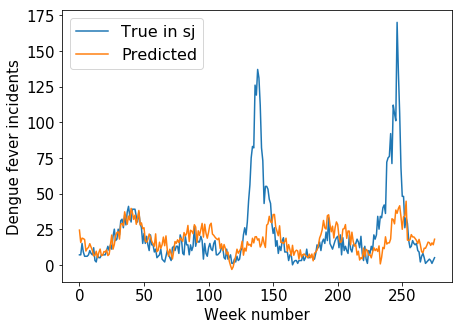

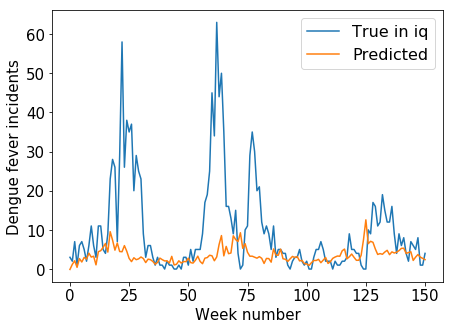

In [175]:
predsj = sj_yp
prediq = iq_yp

cities = ['sj','iq']
for i,(cv,p) in enumerate(zip([sj_ycv,iq_ycv],[predsj,prediq])):
    plt.figure(figsize=(7,5))
    plt.plot(cv,label='True in {}'.format(cities[i]))
    plt.plot(p,label='Predicted')
    plt.xlabel('Week number',fontsize=15)
    plt.ylabel('Dengue fever incidents',fontsize=15)
    plt.legend(prop={'size': 16})
    plt.tick_params(axis='both', which='major', labelsize=15)
    #plt.ylim((0,50))
    plt.show()

## For creating the file for submission

#### Write a new predictor function for each pipeline

In [180]:
def predictor_NNplusRF(Xtr,ytr,Xtest,a,verbose=0):
    # NN
    epochs=40
    inputs = Input(shape=(Xtr.shape[1],))
    layer  = Dense(50,activation='relu',name='D1')(inputs)
    layer  = Dense(50,activation='relu',name='D2')(layer)
    layer  = Dense(1,activation='linear')(layer)
    model  = Model(inputs=inputs,outputs=layer)
    model.compile(loss='mae',optimizer='adam')
    model.fit(Xtr,ytr , epochs=epochs, verbose=verbose)
    yp_nn = model.predict(Xtest)
    yp_nn = yp_nn.reshape(len(yp_nn))
    
    # RF
    #model = RandomForestRegressor(150,'mae',min_samples_split=2,max_features='sqrt')
    model = CatBoostRegressor(iterations=1500,
                          learning_rate=.1,
                          random_strength = 100,
                          depth=7,
                          eval_metric='MAE',
                          random_seed = 23,
                          bagging_temperature = 20,
                          od_type='Iter',
                          metric_period = 100
    )
    model.fit(Xtr,ytr)
    yp_rf = model.predict(Xtest)

    # Combine
    yp = (a*yp_nn+(1-a)*yp_rf)/2
    return yp

#### Create the file

In [190]:
def generateFinalPreds(predictor,shift,skip,fileno=0):
    df_test_sj = getDataSplit(df_test[df_test['city']=='sj'],1)
    df_test_iq = getDataSplit(df_test[df_test['city']=='iq'],1)

    ep = 30
    a  = 0.5
    b  = 0.5
    
    # sj
    sj_XtrAll = np.concatenate((sj_Xtr,sj_Xcv),0)
    sj_ytrAll = np.concatenate((sj_ytr,sj_ycv),0)
    sj_Xtest = sj_pca.transform(df_test_sj)
    sj_Xtest = timeShiftedFeatures(sj_Xtest,None,shift,skip=skip)
    sj_yp_test = np.zeros(len(df_test_sj)).astype(int)
    
    print(
        sj_XtrAll.shape,
        sj_ytrAll.shape,
        sj_Xtest.shape
    )
    
    sj_yp_test[shift:] = predictor(sj_XtrAll,sj_ytrAll,sj_Xtest,a,verbose=0)
    sj_yp_test[:shift] = sj_yp_test[shift]

    # iq
    iq_XtrAll = np.concatenate((iq_Xtr,iq_Xcv),0)
    iq_ytrAll = np.concatenate((iq_ytr,iq_ycv),0)
    iq_Xtest = iq_pca.transform(df_test_iq)
    iq_Xtest = timeShiftedFeatures(iq_Xtest,None,shift,skip=skip)
    iq_yp_test = np.zeros(len(df_test_iq)).astype(int)
    
    iq_yp_test[shift:] = predictor(iq_XtrAll,iq_ytrAll,iq_Xtest,b,verbose=0)
    iq_yp_test[:shift] = iq_yp_test[shift]

    subform = pd.read_csv('data/submission_format.csv')
    subform['total_cases'] = np.concatenate((sj_yp_test,iq_yp_test))
    if fileno>0:
        subform.to_csv('DengAIPreds{:02}.csv'.format(fileno),index=False)
    return subform

In [191]:
subform = generateFinalPreds(predictor_NNplusRF,shift=5,skip=1,fileno=11)

(926, 25) (926,) (255, 25)
0:	learn: 31.5896283	total: 43.7ms	remaining: 1m 5s
100:	learn: 21.1925655	total: 3.8s	remaining: 52.7s
200:	learn: 19.8205126	total: 8.24s	remaining: 53.3s
300:	learn: 18.6892701	total: 13s	remaining: 51.8s
400:	learn: 17.6697677	total: 17.9s	remaining: 49.1s
500:	learn: 16.8314988	total: 21.6s	remaining: 43.1s
600:	learn: 16.0076782	total: 25.3s	remaining: 37.8s
700:	learn: 15.4899958	total: 29s	remaining: 33.1s
800:	learn: 14.9282394	total: 32.6s	remaining: 28.5s
900:	learn: 14.3259311	total: 36.9s	remaining: 24.5s
1000:	learn: 13.8136635	total: 42.4s	remaining: 21.2s
1100:	learn: 13.4115320	total: 46.9s	remaining: 17s
1200:	learn: 12.9482896	total: 50.5s	remaining: 12.6s
1300:	learn: 12.4959556	total: 54.4s	remaining: 8.32s
1400:	learn: 12.2564913	total: 58.2s	remaining: 4.11s
1499:	learn: 11.8604702	total: 1m 1s	remaining: 0us
0:	learn: 7.2444199	total: 46.8ms	remaining: 1m 10s
100:	learn: 4.8390633	total: 4.67s	remaining: 1m 4s
200:	learn: 4.2037922	tot

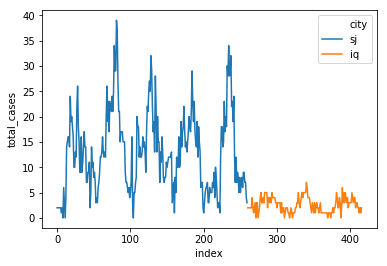

In [192]:
subform['index']=subform.index
sns.lineplot(x='index',y='total_cases',data=subform,hue='city')

In [602]:
subform = subform.drop(columns=['index'])
subform.to_csv('DengAIPreds09.csv',index=False)

In [ ]:
def trans_pca(data,inv='for'):
    if inv in ['for', 0]:
        pass
    
    else:
        pass

In [22]:
class Data:
    def __init__(s,df):
        s.df = df
    
    def read_split_data(s, df, tr_frac, randomise=False, seed=None):
        s.sj_X_train = 1
        s.sj_y_train = 1
        s.sj_X_test = 1
        s.sj_y_test = 1
    
        s.iq_X_train = 1
        s.iq_y_train = 1
        s.iq_X_test = 1
        s.iq_y_test = 1
        
        s.validation = 1 pass
        
    def transform(s, trans_list):
        '''
        trans 
        '''
        pass
        
    def set_model():
        pass
    
    def inverse_transform(s, trans_list):
        for trans in trans_list:
            data = trans(data,'inv')


In [ ]:
class Modelplus:
    def fit(s,data):
        pass
    
    def predict_test(s,data):
        pass
    
    def predict_val(s,data):
        pass
    
class Model_NN1(Modelplus):
    def fx(s,data):
        pass
    
    def fit(s,data):
        'overwrite fit'
        pass


In [ ]:
from my_transformations import pca
from my_transformations import shift

data.transform(pca)
data.transform(shift)

In [21]:
my_data = Data(df)

In [ ]:
from my_models import shift


model = Modelplus()